# **Esempio 1. Approccio ML alla catalogazione di acidi in forti e deboli, e alla regressione della $pk_\textrm{a}$**

## **Obiettivo**
In questo esempio si utilizzeranno gli alberi decisionali con due obiettivi:

1. catalogare un acido come forte o debole

2. predire il valore della $pk_\textrm{a}$ di un acido

L'albero decisionale è un algoritmo di **superviesd learning** basato sull'approccio *divide & conquer*. Si devono, quindi fornire gli esempi sottoforma di coppie $[\mathbf{X}, y]$ dove $\mathbf{X}$ è il vettore delle *features* (descrittori), mentre $y$ è la *label* (etichetta) associata. I descrittori possono essere più di uno, mentre in questo esempio si considererà un problema a singola etichetta.

Per il ML verrà utilizzata la libreria `sklearn`. In particolare, il modulo `tree` per costruire gli alberi decisionali,  il modulo `model_selection.train_test_split` per dividere il dataset in una parte di addestramento e una parte di testing, e il modulo `metrics` per misurare l'accuratezza dell'albero.

Si utilizzerà `pandas` per gestire i dati, e `numpy` per costruire i vettori.

La struttura delle specie chimiche è descritta con il metodo SMILES (*Simplified Molecular Input Line Entry System* - https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). La molecola viene descritta come un grafo ed è possibile risalire a informazioni 2D e 3D in maniera semi-empirica. Tale metodo è stato sviluppato nell'ambito della chemioinformatica.

La libreria `rdkit` per Python implementa il modulo `Chem` che interpreta la stringa in formato SMILES. Può anche disegnare la formula di struttura e ottenere informazioni (descrittori) come cariche parziali, tipologia di legami, atomi accettori/donatori di legami H, ecc.

La libreria `mordred` è specializzata per il calcolo di descrittori molecolari. Difatti, a differenza di `rdkit` che presenta una scelta limitata, `mordred` implementa il calcolo di più di 1800 descrittori.

Se necessario, bisogna innanzitutto installare le librerie `rdkit` e `mordred`.

In [1]:
%%capture
!pip install rdkit
!pip install git+https://github.com/mordred-descriptor/mordred

La cella seguente importa le librerie che serviranno in questo esempio.

In [2]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw

import mordred
from mordred import Calculator
from mordred import HydrogenBond, Polarizability

## **Dataset**
Il file "pka.csv" scaricabile all'URL che è riportato nella cella seguente, raccoglie l'informazione sulla $pk_\textrm{a}$ di diversi acidi. La tabella ha tre colonne che corrispondono a: specie chimica, valore della $pk_\textrm{a}$, e catalogazione se l'acido è forte ($pk_\textrm{a} < 0$) o debole ($pk_\textrm{a} \ge 0$). Nelle cella di codice che segue viene caricato il file come `DataFrame` di `pandas`.

In [3]:
url = 'https://drive.google.com/file/d/12gTXH9xqAarMV1hf8gAtmdTwyBqK7hOW/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

data = pd.read_table(url, encoding='windows-1252', delimiter=';')

display(data)

specie        pka  forza
0       OCl(=O)(=O)=O -10.000000      1
1                [IH]  -9.505150      1
2               [BrH]  -9.000000      1
3               [ClH]  -6.113943      1
4         OS(=O)(=O)O  -3.000000      1
5       O[N+]([O-])=O  -1.380211      1
6        OC(=O)C(=O)O   1.267606     -1
7             OS(O)=O   1.886057     -1
8      OS([O-])(=O)=O   2.000000     -1
9          OP(=O)(O)O   2.148742     -1
10               ON=O   3.142668     -1
11               [FH]   3.180456     -1
12             C(=O)O   3.744727     -1
13     OC(=O)c1ccccc1   4.200659     -1
14  C(=O)(C(=O)[O-])O   4.267606     -1
15            CC(=O)O   4.744727     -1
16      [O-]C([O-])=O   6.356547     -1
17              [SH2]   6.958607     -1
18      OP(=O)(O)[O-]   7.200659     -1
19              [SH-]   2.207608     -1
20                OCl   7.537602     -1
21                C#N   9.207608     -1
22             [NH4+]   9.236572     -1
23             OB(O)O  10.000000     -1
24         OC([O-])=O  10.327902     -1
25   [O-]P(=O)(O)[O-]  12.376751     -1
26        B(O)(O)[O-]  12.744727     -1
27     B(O)([O-])[O-]  13.795880     -1

## **Approccio**
Partendo dall'idea più semplice, si può pensare di addestrare l'albero decisionale usando i valori di $pk_\textrm{a}$ come descrittore e la classificazione forte (1) / debole (-1) come etichetta.

Dato che il confronto del valore di $pk_\textrm{a}$ con 0 è il criterio che cataloga un acido come forte o debole, ci dobbiamo aspettare che per l'algoritmo sia piuttosto facile imparare questa catalogazione.

Affinché l'algoritmo possa imparare, le classi devono essere ben distinguibili tra loro. Una prima analisi da svolgere è quella basata sugli *scatter plot* in cui tutte le coppie di dati vengono rappresentate come punti in uno spazio bidimensionale. Si genera, quindi, una matrice di grafici che mettono in relazione tutte le coppie di dati. Nei grafici "diagonali" si usa rappresentare come istogramma la distribuzione di ciascun tipo di dato.

Il modulo `plotting.scatter_matrix` di `pandas` permette di costruire tale matrice.

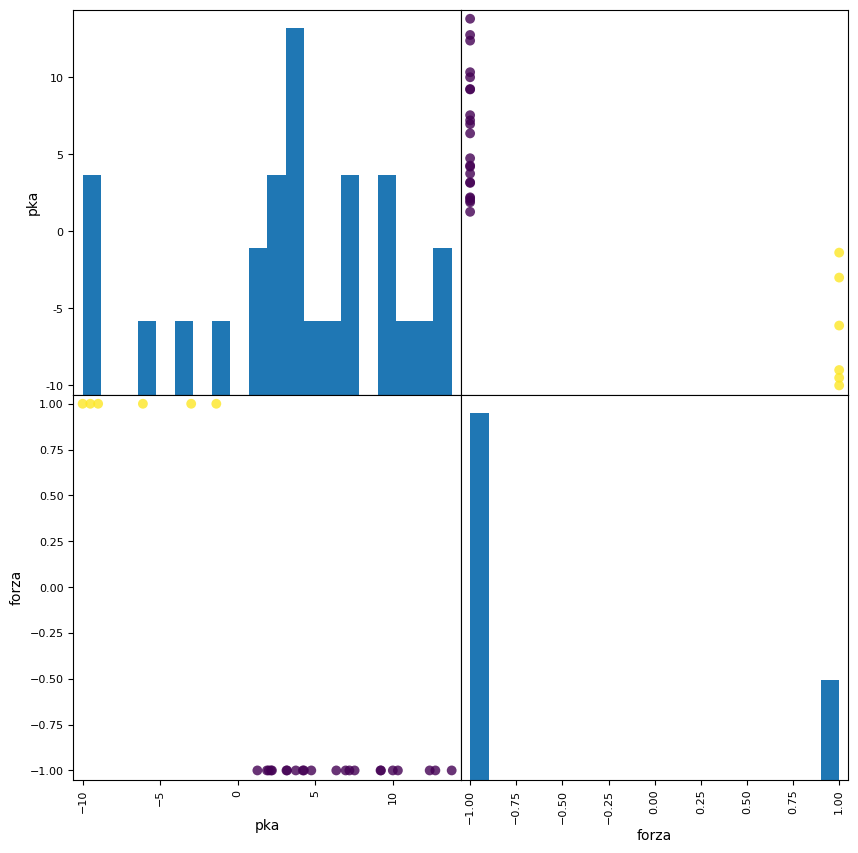

In [ ]:
colors = data['forza'] + 1
grr = pd.plotting.scatter_matrix(data, c = colors, figsize=(10, 10), marker='o', hist_kwds={'bins': 20}, s=50, alpha=0.8)

Risulta evidente quanto avevamo previsto: i dati sono perfettamente separabili. L'accuratezza dell'albero decisionale è attesa essere pari a 1.

Innanzitutto, scegliamo la colonna 1 di `data` come descrittore, e la colonna 2 (intitolata "forza") come etichetta.

In [4]:
features = ['pka']
labels=['forza']

X = data[features]
y = data[labels]

A questo punto, dividiamo il dataset in una parte di addestramento (*training*) e una parte di testing. Di solito, il 70% degli esempi viene usato per l'addestramento.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training e 30% test

Costruiamo e rappresentiamo l'albero decisionale, che effettua classificazione.

[Text(0.5, 0.75, 'x[0] <= -0.056\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]')]

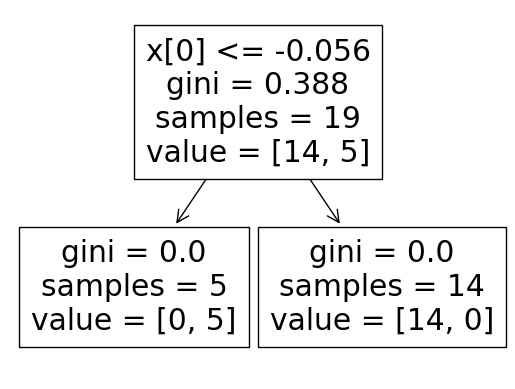

In [ ]:
clf = tree.DecisionTreeClassifier() # costruisce un albero (tree) di classificazione (classifier)
clf = clf.fit(X_train, y_train)     # esegue il training
tree.plot_tree(clf)                 # fornisce in output l'albero

Infine, eseguiamo la fase di test e misuriamo l'accuratezza.

In [6]:
y_pred = clf.predict(X_test) # Esegue la predizione dell'etichetta dei descrittori X_test

# Genera la tabella di confronto tra le etichette generate e i valori già noti
res = pd.DataFrame({'Forza':y_test['forza'],'Predizione':y_pred})
display(res)

# Calcola l'accuratezza
print("\nAccuracy:",metrics.accuracy_score(y_test, y_pred))

NameError: name 'clf' is not defined

Come ci si aspettava, l'accuratezza è del 100%, dato che la $pk_\textrm{a}$ è fortemente correlata alla classificazione forte/debole proprio per il fatto che il valore della $pk_\textrm{a}$ è la discriminante per la catalogazione.

Usare il ML in questo modo triviale non porta a nessuna conoscenza. L'albero decisionale costruito sopra ha generato un rudimentale algoritmo di intelligenza artificiale (IA). Un algortimo IA è basato su conoscenze fornite da umani "esperti". In questo caso, il semplice codice:


```
pka = input()
if (pka < 0)
  print ('forte')
else
  print ('debole')
```

fa già quello che l'albero decisionale ha imparato, tra l'altro con un dataset molto limitato.

# **Descrittori molecolari**

Può risultare più interessante cercare correlazioni tra descrittori molecolari e la catalogazione di un acido come forte o debole.

Si deve sempre ricordare il detto ***correlation is not causation***, e che il ML si basa sull'evidenziare le correlazioni tra i dati. Detto questo, però, a fronte di uno spazio di descrittori molto elevato, riuscire a determinare una gerarchia di importanza può essere utile a focalizzare il ragionamento umano verso le proprietà più importanti per spiegare un'osservazione.

Questo modo di interpretare la *data-science* è importante allo scopo di utilizzare i risultati di un modello ML per la ricerca scientifica. L'idea è alla base di quello che viene chiamato *interpretable ML*, ossia approcci ML in cui l'operatore umano è in grado di comprendere (nella direzione di collegare a principi primi) ciò che l'algoritmo di ML ha appreso.

Proviamo a scegliere qualche descrittore che ragionevolmente sembra rilevante nel determinare la forza di un acido e proviamo a costruire un nuovo albero decisionale basato su tali descrittori.

## **Definizione e calcolo dei descrittori molecolari**
La molecola è interpretabile in un'infinità di modi differenti. Può essere vista come una stringa alfa-numerica che fornisce la formula bruta, un grafo (come in `rdkit`), una collezione di coordinate Cartesiane degli atomi, il suo peso molecolare, il tensore d'inerzia, la polarizzazione, l'energia elettronica di stato fondamentale, le frequenze di vibrazione caratteristiche, ecc. Si tratta di uno spazio di descrittori così ampio da esplorare che, da una parte, rende complicato individuare quelli che sono più "idonei" al problema che si sta studiando, ma d'altra parte offre un grado di libertà molto ampio per poter applicare il ML alla *data driven chemistry*.

A questa pagina si trova la lista completa dei descrittori che possono essere calcolati da `mordred`: https://mordred-descriptor.github.io/documentation/master/descriptors.html. Proviamo a usare la polarzzabilità di atomi e legami e la capacità degli atomi della molecola di essere accettori/donatori di legami H.

Usiamo il modulo `rdkit.Chem` per interpretare le stringhe SMILES del dataset.

In [8]:
smiles_str = data.specie.astype(str).to_list()
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_str]

Rappresentiamo le molecole usando il valore della $pk_\textrm{a}$ come legenda.

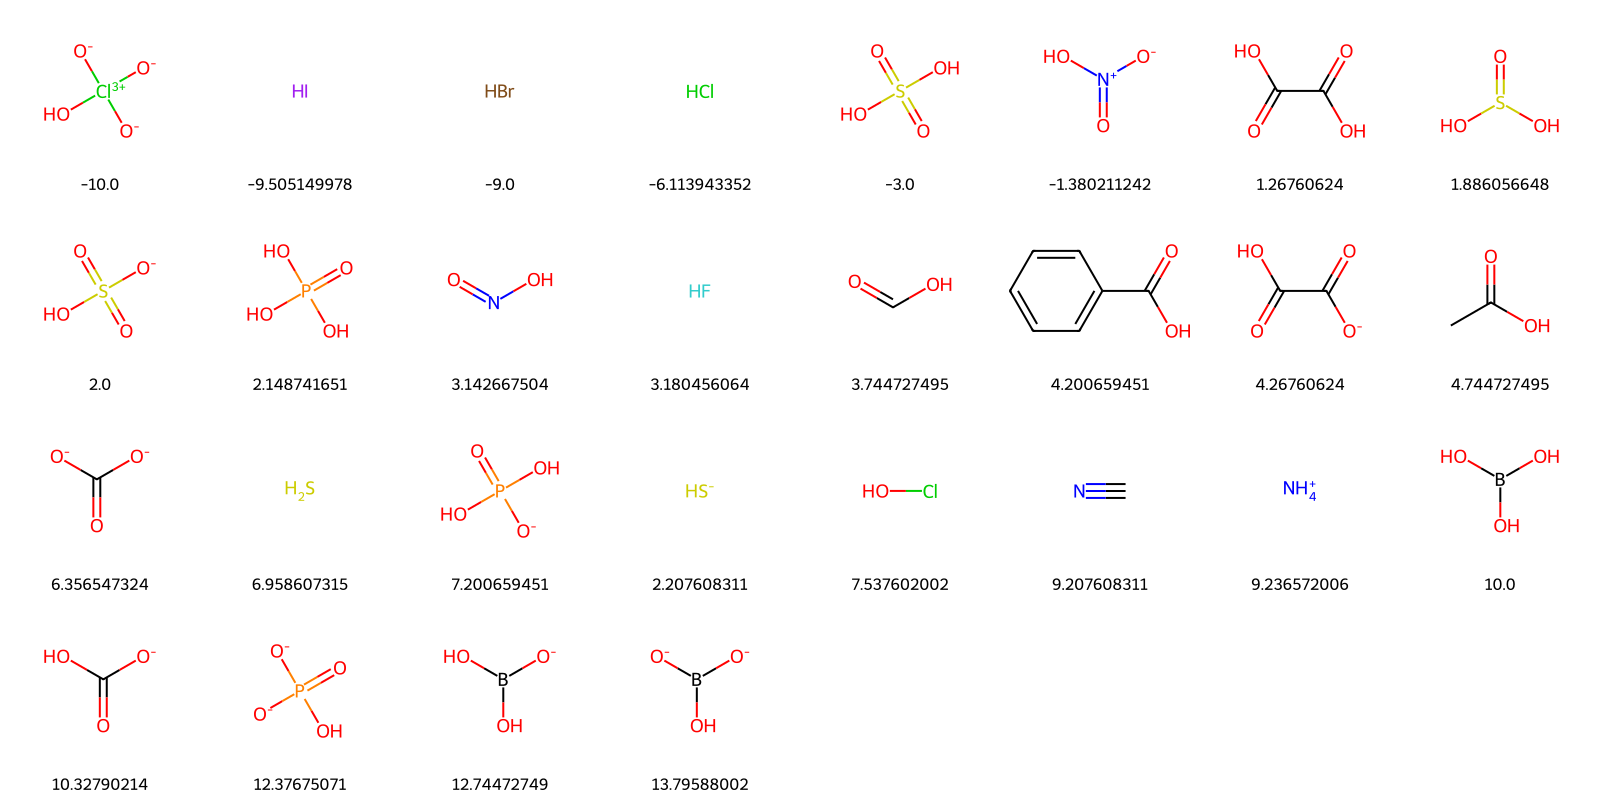

In [9]:
Draw.MolsToGridImage(mols, molsPerRow=8,subImgSize=(200,200), legends=[str(x) for x in data['pka']])

Nella cella seguente viene impostato il motore di `mordered` a calcolare i descrittori scelti e poi il calcolatore viene applicato alla lista `mols`. I descrittori appena calcolati vengono salvati nel `DataFrame` chiamato `descr`. Il risultato viene rappresentato come tabella. I termini apol e bpol indicano, rispettivamente, la polarizzabilità degli atomi e dei legami. Le variabili nHBAcc e nHBDon contano, rispettivamente, gli atomi accettori e donatori di legami H.

In [10]:
# Crea il calcolatore di descrittori
calc = Calculator()

# Aggiunge i descrittori da calcolare
calc.register(Polarizability)
calc.register(HydrogenBond)

# Crea il DataFrame con i descrittori
descr = calc.pandas(mols)
display(descr)

100%|██████████| 28/28 [00:00<00:00, 92.89it/s]


apol       bpol  nHBAcc  nHBDon
0    6.054793   5.647207       4       1
1    6.016793   4.683207       0       0
2    3.716793   2.383207       0       0
3    2.846793   1.513207       0       0
4    7.441586   8.662414       2       2
5    4.172793   1.029207       2       1
6    7.881586   3.742414       2       2
7    6.639586   6.564414       1       2
8    6.774793   8.527207       3       1
9    8.838379  11.717621       1       3
10   3.370793   0.731207       2       1
11   1.223793   0.109793       0       0
12   4.607586   2.874414       1       1
13  17.294758   6.887242       1       1
14   7.214793   3.607207       3       1
15   7.611172   4.880828       1       1
16   4.076000   2.604000       3       0
17   4.233586   4.466414       0       0
18   8.171586  11.582414       2       2
19   3.566793   2.233207       1       0
20   3.648793   1.513207       1       1
21   3.436793   1.573207       1       0
22   3.767172   1.732828       0       1
23   7.436379   7.089621       3       3
24   4.742793   2.739207       2       1
25   7.504793  11.447207       3       1
26   6.769586   6.954414       3       2
27   6.102793   6.819207       3       1

Generiamo ora un nuovo DataFrame mettendo assieme il contenuto del dataset iniziale e i descrittori appena calcolati.

In [11]:
data2 = data.copy(deep = True)
data2.insert(1, 'apol', descr['apol'])
data2.insert(2, 'bpol', descr['bpol'])
data2.insert(3, 'HA', descr['nHBAcc'])
data2.insert(4, 'HD', descr['nHBDon'])
display(data2)

specie       apol       bpol  HA  HD        pka  forza
0       OCl(=O)(=O)=O   6.054793   5.647207   4   1 -10.000000      1
1                [IH]   6.016793   4.683207   0   0  -9.505150      1
2               [BrH]   3.716793   2.383207   0   0  -9.000000      1
3               [ClH]   2.846793   1.513207   0   0  -6.113943      1
4         OS(=O)(=O)O   7.441586   8.662414   2   2  -3.000000      1
5       O[N+]([O-])=O   4.172793   1.029207   2   1  -1.380211      1
6        OC(=O)C(=O)O   7.881586   3.742414   2   2   1.267606     -1
7             OS(O)=O   6.639586   6.564414   1   2   1.886057     -1
8      OS([O-])(=O)=O   6.774793   8.527207   3   1   2.000000     -1
9          OP(=O)(O)O   8.838379  11.717621   1   3   2.148742     -1
10               ON=O   3.370793   0.731207   2   1   3.142668     -1
11               [FH]   1.223793   0.109793   0   0   3.180456     -1
12             C(=O)O   4.607586   2.874414   1   1   3.744727     -1
13     OC(=O)c1ccccc1  17.294758   6.887242   1   1   4.200659     -1
14  C(=O)(C(=O)[O-])O   7.214793   3.607207   3   1   4.267606     -1
15            CC(=O)O   7.611172   4.880828   1   1   4.744727     -1
16      [O-]C([O-])=O   4.076000   2.604000   3   0   6.356547     -1
17              [SH2]   4.233586   4.466414   0   0   6.958607     -1
18      OP(=O)(O)[O-]   8.171586  11.582414   2   2   7.200659     -1
19              [SH-]   3.566793   2.233207   1   0   2.207608     -1
20                OCl   3.648793   1.513207   1   1   7.537602     -1
21                C#N   3.436793   1.573207   1   0   9.207608     -1
22             [NH4+]   3.767172   1.732828   0   1   9.236572     -1
23             OB(O)O   7.436379   7.089621   3   3  10.000000     -1
24         OC([O-])=O   4.742793   2.739207   2   1  10.327902     -1
25   [O-]P(=O)(O)[O-]   7.504793  11.447207   3   1  12.376751     -1
26        B(O)(O)[O-]   6.769586   6.954414   3   2  12.744727     -1
27     B(O)([O-])[O-]   6.102793   6.819207   3   1  13.795880     -1

Qui di seguito viene creata la nuova *scatter matrix* con tutti dati. I punti sono colorati sempre in funzione della catalogazione dell'acido in forte/debole.

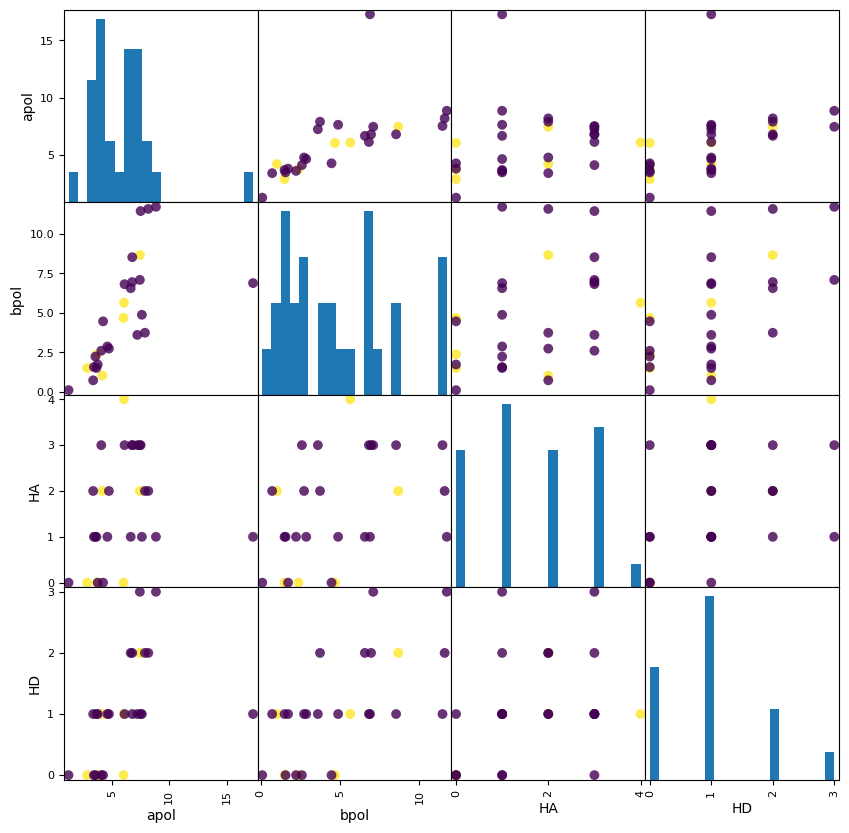

In [13]:
colors = data2['forza'] + 1
grr = pd.plotting.scatter_matrix(data2[['apol', 'bpol', 'HA', 'HD']], c = colors, figsize=(10, 10), marker='o', hist_kwds={'bins': 20}, s=50, alpha=0.8)

## **Catalogazione basata su descrittore e $pk_\textrm{a}$**
Proviamo innanzitutto a creare un albero decisionale usando i nuovi descrittori, assieme alla $pk_\textrm{a}$.

[Text(0.5, 0.75, 'x[4] <= -0.056\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]')]

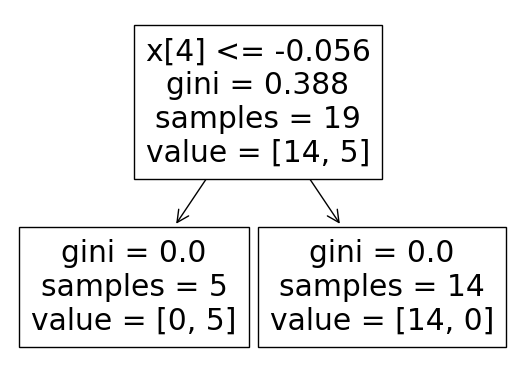

In [15]:
features = ['apol', 'bpol', 'HA', 'HD', 'pka']
labels=['forza']

X = data2[features]
y = data2[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)

Come si può vedere, l'albero decisionale si concentra solo sul descrittore più rilevante, ossia il valore della $pk_\textrm{a}$: tale valore è sufficiente, ed è il più efficiente, a catalogare gli acidi.

Intuitivamente possiamo aspettarci che la capacità di dare legami idrogeno sia correlabile alla forza di un acido. Vediamo come funziona questa scelta.

[Text(0.5, 0.9166666666666666, 'x[0] <= 0.5\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.3333333333333333, 0.75, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.6666666666666666, 0.75, 'x[0] <= 3.5\ngini = 0.305\nsamples = 16\nvalue = [13, 3]'),
 Text(0.5, 0.5833333333333334, 'x[0] <= 2.5\ngini = 0.231\nsamples = 15\nvalue = [13, 2]'),
 Text(0.3333333333333333, 0.4166666666666667, 'x[0] <= 1.5\ngini = 0.346\nsamples = 9\nvalue = [7, 2]'),
 Text(0.16666666666666666, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.5, 0.25, 'x[1] <= 1.5\ngini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(0.3333333333333333, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6666666666666666, 0.08333333333333333, 'gini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.6666666666666666, 0.4166666666666667, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.8333333333333334, 0.5833333333333334, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

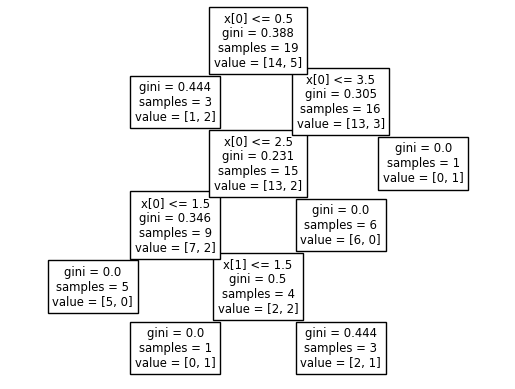

In [ ]:
features = ['HA', 'HD']
labels=['forza']

X = data2[features]
y = data2[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)

L'albero ora appare un po' più complesso di prima e utilizza entrambi i descrittori. Testiamolo!

In [ ]:
y_pred = clf.predict(X_test)
res = pd.DataFrame({'Forza':y_test['forza'],'Predizione':y_pred})
display(res)

print("\nAccuracy:",metrics.accuracy_score(y_test, y_pred))

Forza  Predizione
24     -1           1
17     -1           1
19     -1          -1
20     -1          -1
14     -1          -1
3       1           1
22     -1           1
10     -1           1
21     -1          -1


Accuracy: 0.5555555555555556


Come ci si poteva aspettare, adesso l'azione dell'albero è meno efficace e ha un'accuratezza del 56%. Significa che sostanzialmente va a caso.

Potrebbe essere un problema di *overfitting*. Proviamo a migliorare la situazione richiedendo un albero meno dettagliato.

[Text(0.4, 0.875, 'x[0] <= 0.5\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.2, 0.625, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.6, 0.625, 'x[0] <= 3.5\ngini = 0.305\nsamples = 16\nvalue = [13, 3]'),
 Text(0.4, 0.375, 'x[0] <= 2.5\ngini = 0.231\nsamples = 15\nvalue = [13, 2]'),
 Text(0.2, 0.125, 'gini = 0.346\nsamples = 9\nvalue = [7, 2]'),
 Text(0.6, 0.125, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.8, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

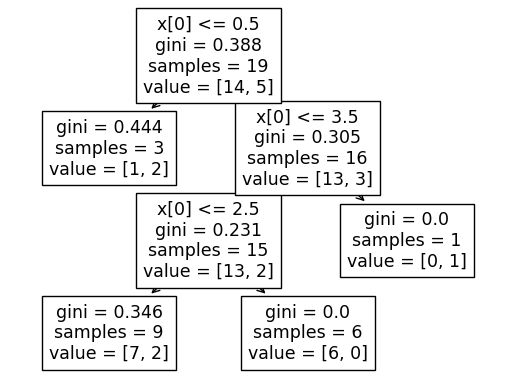

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3) # max_depth è l'iperparametro che regola la capacità dell'algoritmo di apprendere
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)

Testiamo il nuovo albero.

In [ ]:
y_pred = clf.predict(X_test)
res = pd.DataFrame({'Forza':y_test['forza'],'Predizione':y_pred})
display(res)

print("\nAccuracy:",metrics.accuracy_score(y_test, y_pred))

Forza  Predizione
24     -1          -1
17     -1           1
19     -1          -1
20     -1          -1
14     -1          -1
3       1           1
22     -1           1
10     -1          -1
21     -1          -1


Accuracy: 0.7777777777777778


Molto meglio! Riducendo la complessità dell'albero decisionale, l'algoritmo si concentra di meno su dettagli che distinguono ogni singolo dato, in favore di una visione un po' più generale degli esempi e quindi (anche se sembra paradossale) ad un migliore apprendimento. Un'accuratezza del 78% è ritenuta ottima per un albero decisionale.

# **Regressione**

Gli alberi decisionali possono essere utilizzati anche in problemi di regressione, ossia nel caso in cui l'etichetta assegnata ai descrittori sia una variabile continua. Dato che l'informazione sulla presenza di atomi accettori e donatori di legami H ha portato a catalogare un acido tra forte o debole, magari con tale descrittore possiamo anche provare a stimare la $pk_\textrm{a}$.

Per prima cosa analizziamo i dati tramite la *scatter matrix*, questa volta usando la $pk_\textrm{a}$ per dare un codice colore ai punti.

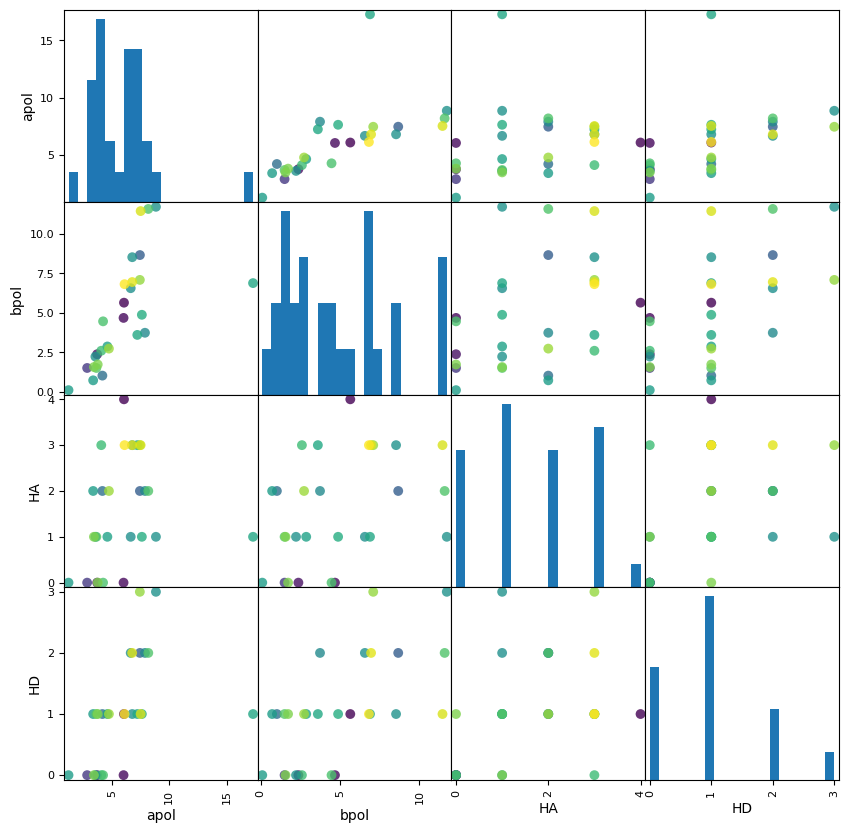

In [17]:
colors = data2['pka']
grr = pd.plotting.scatter_matrix(data2[['apol', 'bpol', 'HA', 'HD']], c = colors, figsize=(10, 10), marker='o', hist_kwds={'bins': 20}, s=50, alpha=0.8)

Proviamo a costruire un albero decisionale di regressione con HA, HD come descrittori e pka come etichetta.

[Text(0.5, 0.9, 'x[0] <= 0.5\nsquared_error = 48.0\nsamples = 19\nvalue = 2.777'),
 Text(0.375, 0.7, 'squared_error = 34.394\nsamples = 3\nvalue = -5.108'),
 Text(0.625, 0.7, 'x[0] <= 3.5\nsquared_error = 36.708\nsamples = 16\nvalue = 4.255'),
 Text(0.5, 0.5, 'x[0] <= 2.5\nsquared_error = 24.704\nsamples = 15\nvalue = 5.206'),
 Text(0.25, 0.3, 'x[0] <= 1.5\nsquared_error = 8.732\nsamples = 9\nvalue = 2.313'),
 Text(0.125, 0.1, 'squared_error = 1.282\nsamples = 5\nvalue = 3.345'),
 Text(0.375, 0.1, 'squared_error = 15.046\nsamples = 4\nvalue = 1.022'),
 Text(0.75, 0.3, 'x[1] <= 0.5\nsquared_error = 17.271\nsamples = 6\nvalue = 9.546'),
 Text(0.625, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = 6.357'),
 Text(0.875, 0.1, 'squared_error = 18.285\nsamples = 5\nvalue = 10.183'),
 Text(0.75, 0.5, 'squared_error = 0.0\nsamples = 1\nvalue = -10.0')]

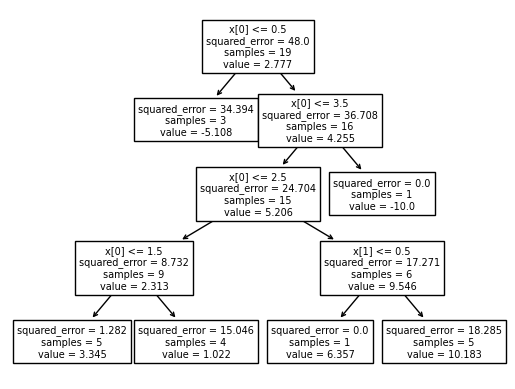

In [18]:
features = ['HA', 'HD']
labels=['pka']

X = data2[features]
y = data2[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = tree.DecisionTreeRegressor(max_depth=4) # Crea un albero di regressione
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)

E vai con il test!

In [ ]:
y_pred = clf.predict(X_test)
res = pd.DataFrame({'pka':y_test['pka'],'Predizione':y_pred})
display(res)

print('\nr2_score = ', metrics.r2_score(y_test, y_pred)**2)
print('MAE = ', metrics.mean_absolute_error(y_test, y_pred)**2)

pka  Predizione
24  10.327902    1.022014
17   6.958607   -5.108231
19   2.207608    3.344983
20   7.537602    3.344983
14   4.267606   10.183472
3   -6.113943   -5.108231
22   9.236572   -5.108231
10   3.142668    1.022014
21   9.207608    3.344983


r2_score =  2.374347910956538
MAE =  38.65023417436451


Proviamo a usare anche apol e bpol come descrittori.

[Text(0.625, 0.9, 'x[2] <= 3.5\nsquared_error = 37.301\nsamples = 19\nvalue = 3.794'),
 Text(0.5416666666666666, 0.7, 'x[2] <= 2.5\nsquared_error = 28.215\nsamples = 18\nvalue = 4.56'),
 Text(0.3333333333333333, 0.5, 'x[0] <= 3.109\nsquared_error = 22.737\nsamples = 13\nvalue = 3.05'),
 Text(0.16666666666666666, 0.3, 'x[0] <= 2.035\nsquared_error = 21.596\nsamples = 2\nvalue = -1.467'),
 Text(0.08333333333333333, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = 3.18'),
 Text(0.25, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = -6.114'),
 Text(0.5, 0.3, 'x[1] <= 3.241\nsquared_error = 18.561\nsamples = 11\nvalue = 3.871'),
 Text(0.4166666666666667, 0.1, 'squared_error = 16.921\nsamples = 7\nvalue = 5.754'),
 Text(0.5833333333333334, 0.1, 'squared_error = 4.364\nsamples = 4\nvalue = 0.576'),
 Text(0.75, 0.5, 'x[0] <= 6.439\nsquared_error = 21.098\nsamples = 5\nvalue = 8.488'),
 Text(0.6666666666666666, 0.3, 'squared_error = 0.0\nsamples = 1\nvalue = 13.796'),
 Text(0.8333333333333334, 0.

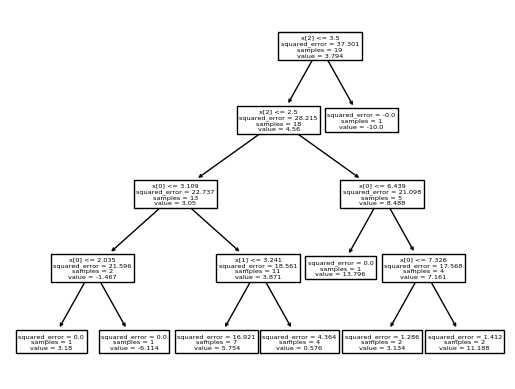

In [20]:
features = ['apol', 'bpol', 'HA', 'HD']
labels=['pka']

X = data2[features]
y = data2[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3) # 70% training and 30% test

clf = tree.DecisionTreeRegressor(max_depth=4)
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)

In [ ]:
y_pred = clf.predict(X_test)
res = pd.DataFrame({'pka':y_test['pka'],'Predizione':y_pred})
display(res)

print('\nr2_score = ', metrics.r2_score(y_test, y_pred))
print('MAE = ', metrics.mean_absolute_error(y_test, y_pred))

pka  Predizione
18   7.200659    7.537602
17   6.958607    7.537602
12   3.744727    3.530243
26  12.744727   13.795880
15   4.744727    3.530243
16   6.356547    7.537602
13   4.200659    3.530243
2   -9.000000   -6.113943
1   -9.505150   -6.113943


r2_score =  0.9443775382842521
MAE =  1.2805324836666667


E questo è meraviglioso.